In [1]:
# Imports
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier

from instagram_private_api import Client, ClientCompatPatch
import getpass

import random

# Part 1: Data Interpretation and Splitting 

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
#Examine the training data.
train.head(5)

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.27,0,0.0,0,53,0,0,32,1000,955,0
1,1,0.00,2,0.0,0,44,0,0,286,2740,533,0
2,1,0.10,2,0.0,0,0,0,1,13,159,98,0
3,1,0.00,1,0.0,0,82,0,0,679,414,651,0
4,1,0.00,2,0.0,0,0,0,1,6,151,126,0


In [4]:
#The features Description:
 
#1-profile pic: does the user have a profile picture?
#2-nums/length username: ratio of numerical to alphabetical characters in the username
#3-fullname words: how many words are in the user's full name?
#4-nums/length fullname: ratio of numerical to alphabetical characters in the full name
#5-name==username: is the user's full name the same as the username?
#6-description length: how many characters is in the user's Instagram bio?
#7-external URL: does the user have an external URL linked to their profile?
#8-private: is the user private?
#9-posts: number of posts
#10-followers: number of people following the user
#11-follows: number of people the user follows
#12-fake: if the user is fake, fake=1, else fake=0

In [5]:
train.describe()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,5.760000e+02,576.000000,576.000000
mean,0.701389,0.163837,1.460069,0.036094,0.034722,22.623264,0.116319,0.381944,107.489583,8.530724e+04,508.381944,0.500000
std,0.458047,0.214096,1.052601,0.125121,0.183234,37.702987,0.320886,0.486285,402.034431,9.101485e+05,917.981239,0.500435
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.900000e+01,57.500000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.505000e+02,229.500000,0.500000
75%,1.000000,0.310000,2.000000,0.000000,0.000000,34.000000,0.000000,1.000000,81.500000,7.160000e+02,589.500000,1.000000
max,1.000000,0.920000,12.000000,1.000000,1.000000,150.000000,1.000000,1.000000,7389.000000,1.533854e+07,7500.000000,1.000000


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   profile pic           576 non-null    int64  
 1   nums/length username  576 non-null    float64
 2   fullname words        576 non-null    int64  
 3   nums/length fullname  576 non-null    float64
 4   name==username        576 non-null    int64  
 5   description length    576 non-null    int64  
 6   external URL          576 non-null    int64  
 7   private               576 non-null    int64  
 8   #posts                576 non-null    int64  
 9   #followers            576 non-null    int64  
 10  #follows              576 non-null    int64  
 11  fake                  576 non-null    int64  
dtypes: float64(2), int64(10)
memory usage: 54.1 KB


In [7]:
train.shape

(576, 12)

In [8]:
#Examine the test data.
test.head(5)

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.33,1,0.33,1,30,0,1,35,488,604,0
1,1,0.00,5,0.00,0,64,0,1,3,35,6,0
2,1,0.00,2,0.00,0,82,0,1,319,328,668,0
3,1,0.00,1,0.00,0,143,0,1,273,14890,7369,0
4,1,0.50,1,0.00,0,76,0,1,6,225,356,0


In [9]:
test.describe()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,1.200000e+02,120.000000,120.000000
mean,0.758333,0.179917,1.550000,0.071333,0.041667,27.200000,0.100000,0.308333,82.866667,4.959472e+04,779.266667,0.500000
std,0.429888,0.241492,1.187116,0.209429,0.200664,42.588632,0.301258,0.463741,230.468136,3.816126e+05,1409.383558,0.502096
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.725000e+01,119.250000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2.165000e+02,354.500000,0.500000
75%,1.000000,0.330000,2.000000,0.000000,0.000000,45.250000,0.000000,1.000000,58.250000,5.932500e+02,668.250000,1.000000
max,1.000000,0.890000,9.000000,1.000000,1.000000,149.000000,1.000000,1.000000,1879.000000,4.021842e+06,7453.000000,1.000000


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   profile pic           120 non-null    int64  
 1   nums/length username  120 non-null    float64
 2   fullname words        120 non-null    int64  
 3   nums/length fullname  120 non-null    float64
 4   name==username        120 non-null    int64  
 5   description length    120 non-null    int64  
 6   external URL          120 non-null    int64  
 7   private               120 non-null    int64  
 8   #posts                120 non-null    int64  
 9   #followers            120 non-null    int64  
 10  #follows              120 non-null    int64  
 11  fake                  120 non-null    int64  
dtypes: float64(2), int64(10)
memory usage: 11.4 KB


In [11]:
test.shape

(120, 12)

In [12]:
#Check for NULL values
print(train.isna().values.any().sum())
print(test.isna().values.any().sum())

0
0


0    288
1    288
Name: fake, dtype: int64


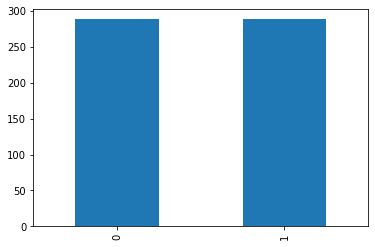

In [14]:
## checking the balance of the data by plotting the count of outcomes by their value
color_wheel = {1: "#0392cf", 
               2: "#7bc043"}
colors = train["fake"].map(lambda x: color_wheel.get(x + 1))
print(train.fake.value_counts())
p=train.fake.value_counts().plot(kind="bar")

0    60
1    60
Name: fake, dtype: int64


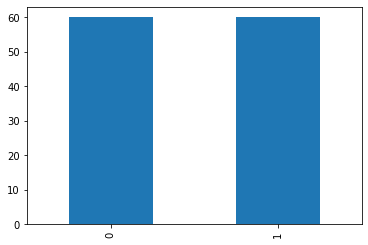

In [15]:
## checking the balance of the data by plotting the count of outcomes by their value
color_wheel = {1: "#0392cf", 
               2: "#7bc043"}
colors = test["fake"].map(lambda x: color_wheel.get(x + 1))
print(test.fake.value_counts())
p=test.fake.value_counts().plot(kind="bar")

C:\Users\96655\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


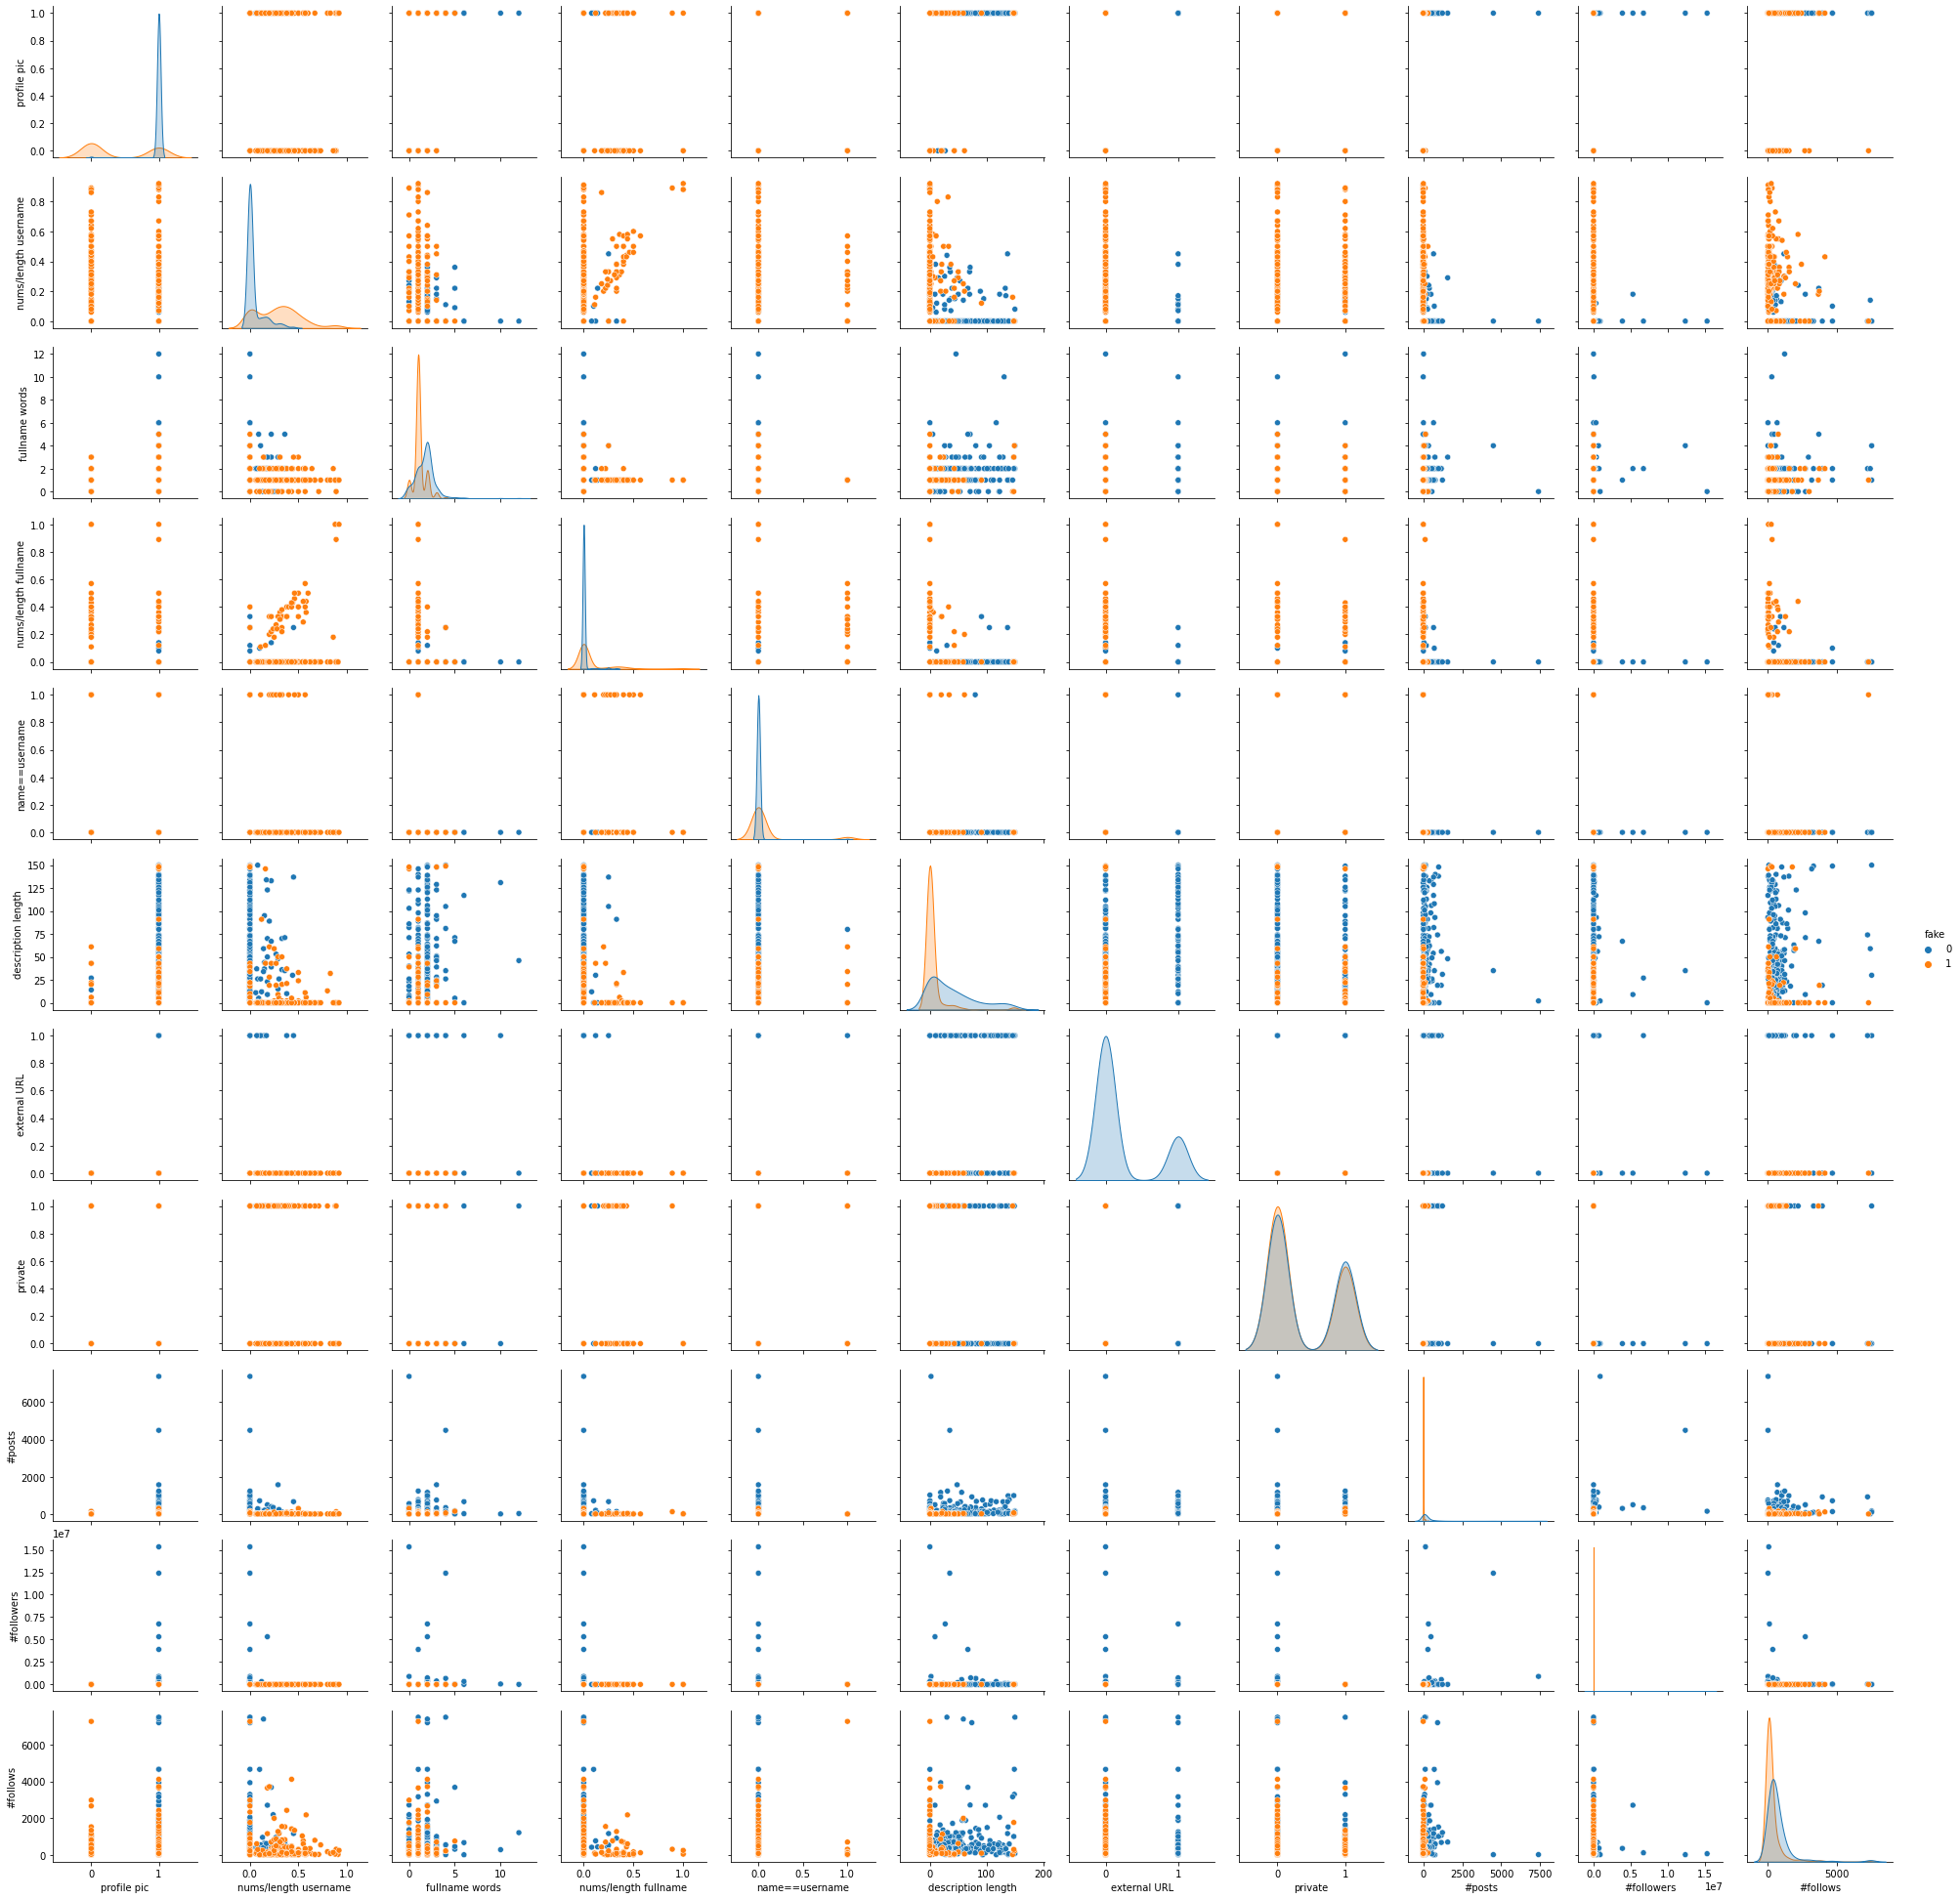

In [16]:
p=sns.pairplot(train, hue = 'fake')

<AxesSubplot:>

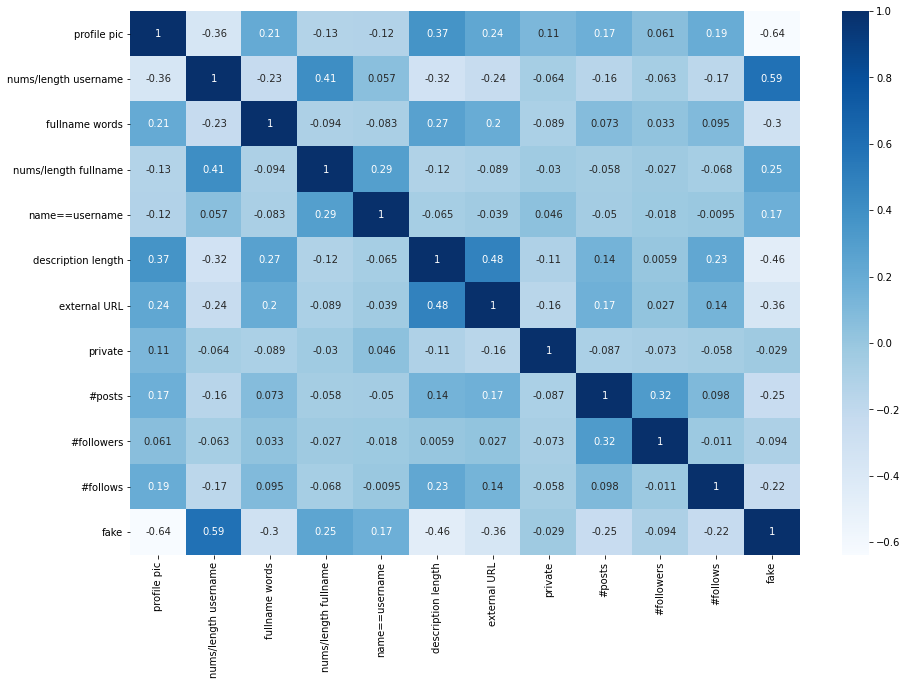

In [17]:
#To check for significantly relevant features, create a correlation matrix for the features in the training data.
fig, ax = plt.subplots(figsize=(15,10))  
corr=train.corr()
sns.heatmap(corr, annot=True,cmap="Blues")

In [18]:
#Split the training set into data and labels

# Labels
train_Y = train.fake
train_Y = pd.DataFrame(train_Y)

# Data
train_X = train.drop(columns='fake')

train_Y.head()

,fake
0,0
1,0
2,0
3,0
4,0


In [19]:
train_X.head()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows
0,1,0.27,0,0.0,0,53,0,0,32,1000,955
1,1,0.00,2,0.0,0,44,0,0,286,2740,533
2,1,0.10,2,0.0,0,0,0,1,13,159,98
3,1,0.00,1,0.0,0,82,0,0,679,414,651
4,1,0.00,2,0.0,0,0,0,1,6,151,126


In [20]:
#Split the test set into data and labels

# Labels
test_Y = test.fake
test_Y = pd.DataFrame(test_Y)

# Data
test_X = test.drop(columns='fake')
test_Y

,fake
0,0
1,0
2,0
3,0
4,0
...,...
115,1
116,1
117,1
118,1


In [21]:
test_X.head()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows
0,1,0.33,1,0.33,1,30,0,1,35,488,604
1,1,0.00,5,0.00,0,64,0,1,3,35,6
2,1,0.00,2,0.00,0,82,0,1,319,328,668
3,1,0.00,1,0.00,0,143,0,1,273,14890,7369
4,1,0.50,1,0.00,0,76,0,1,6,225,356


# Part 2: Comparing Classification Models

In [22]:
# Baseline classifier
fakes = len([i for i in train.fake if i==1])
auth = len([i for i in train.fake if i==0])
fakes, auth

# classify everything as fake
pred = [1 for i in range(len(test_X))]
pred = np.array(pred)
print("Baseline Accuracy: " + str(accuracy_score(pred, test_Y)))

Baseline Accuracy: 0.5


Maximum Accuracy for the statistical method: 0.7


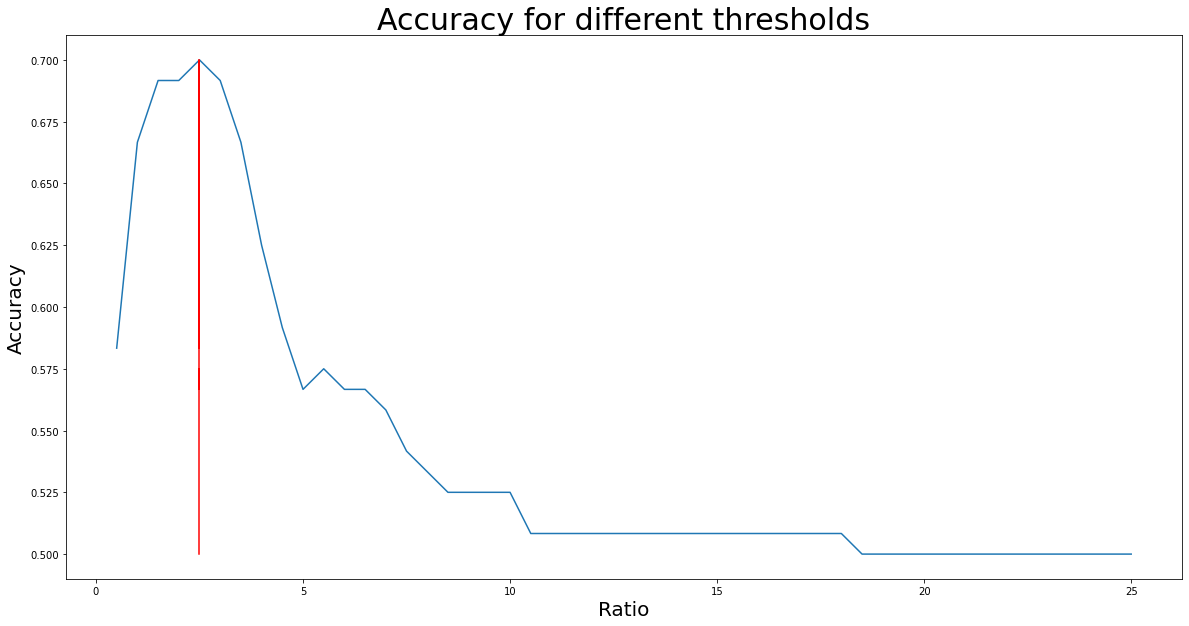

In [23]:
#Statistical Method

#All users having a follower-to-follower ratio greater than a specific level should be labeled as "fake."
#For example, if the r=20 criterion is met, a user with 10 followers and 200 followers will be labeled a fake.
def stat_predict(test_X, r):
    pred = []
    for row in range(len(test_X)):   
        followers = test_X.loc[row]['#followers']
        followings = test_X.loc[row]['#follows']
        if followers == 0:
            followers = 1
        if followings == 0:
            followings == 1

        ratio = followings/followers

        if ratio >= r:
            pred.append(1)
        else:
            pred.append(0)
    
    return np.array(pred)
accuracies = []
for i in [x / 10.0 for x in range(5, 255, 5)]:
    prediction = stat_predict(test_X, i)
    accuracies.append(accuracy_score(prediction, test_Y))

f, ax = plt.subplots(figsize=(20,10))
plt.plot([x / 10.0 for x in range(5, 255, 5)], accuracies)
plt.plot([2.5 for i in range(len(accuracies))], accuracies, color='red')
plt.title("Accuracy for different thresholds", size=30)
plt.xlabel('Ratio', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
print("Maximum Accuracy for the statistical method: " + str(max(accuracies)))

## Logistic Regression

In [30]:
lm = LogisticRegression()

# Train the model
model1_LR = lm.fit(train_X, train_Y)

# Make a prediction
lm_predict = model1_LR.predict(test_X)

C:\Users\96655\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\96655\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
# Compute the accuracy of the model
accuracy = accuracy_score(lm_predict, test_Y)
print("Logistic Regression accuracy: " + str(accuracy))

Logistic Regression accuracy: 0.9083333333333333


Text(0.5, 15.0, 'Predicted label')

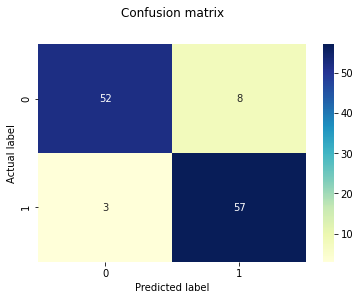

In [32]:
#confusion_matrix

y_pred = lm.predict(test_X)
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(test_Y, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [33]:
# Precision = TruePositive (TP)/ (TruePositive (TP) + FalsePositive (FP) 
print(precision_score(model1_LR.predict(test_X),test_Y))
# Recall = TruePositive (TP)/ (TruePositive (TP) + FalseNegative (FN) 
print(recall_score(model1_LR.predict(test_X),test_Y))
# F1 − Score = 2 × (Precision × Recall)/ (Precision + Recall)
print(f1_score(model1_LR.predict(test_X),test_Y))

0.95
0.8769230769230769
0.912


In [34]:
#import classification_report
from sklearn.metrics import classification_report
print(classification_report(test_Y,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.87      0.90        60
           1       0.88      0.95      0.91        60

    accuracy                           0.91       120
   macro avg       0.91      0.91      0.91       120
weighted avg       0.91      0.91      0.91       120



## KNN Classifier

C:\Users\96655\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\96655\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\96655\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\96655\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

The highest accuracy obtained using KNN is 0.8666666666666667 achieved by a value of n=7


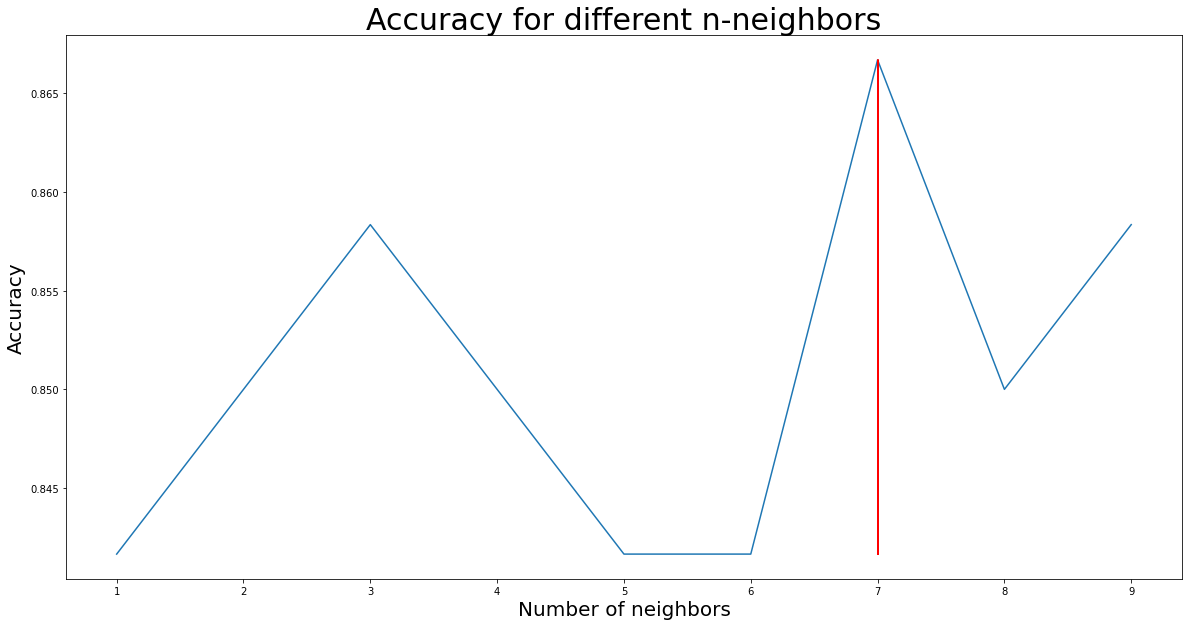

In [35]:
accuracies = []

# Compare the accuracies of using the KNN classifier with different number of neighbors
for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=i)
    model2_KNN = knn.fit(train_X,train_Y)
    knn_predict = model2_KNN.predict(test_X)
    accuracy = accuracy_score(knn_predict,test_Y)
    accuracies.append(accuracy)

max_acc = (0, 0)
for i in range(1, 10):
    if accuracies[i-1] > max_acc[1]:
        max_acc = (i, accuracies[i-1])

max_acc

f, ax = plt.subplots(figsize=(20,10))
plt.plot([i for i in range(1,10)], accuracies)
plt.plot([7 for i in range(len(accuracies))], accuracies, color='red')
plt.title("Accuracy for different n-neighbors", size=30)
plt.xlabel('Number of neighbors', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)

print("The highest accuracy obtained using KNN is " + str(max_acc[1]) + " achieved by a value of n=" + str(max_acc[0]))

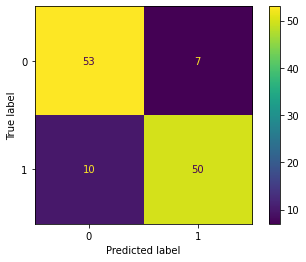

In [36]:
#confusion_matrix
plot_confusion_matrix(model2_KNN,test_X,test_Y) 

In [37]:
# Precision 
print(precision_score(model2_KNN.predict(test_X),test_Y))
# Recall
print(recall_score(model2_KNN.predict(test_X),test_Y))
# F1 − Score 
print(f1_score(model2_KNN.predict(test_X),test_Y))

0.8333333333333334
0.8771929824561403
0.8547008547008548


## Decision Tree Classifier

In [38]:
DT = DecisionTreeClassifier()

# Train the model
model3_DT = DT.fit(train_X, train_Y)

# Make a prediction
DT_predict = model3_DT.predict(test_X)

In [39]:
# Compute the accuracy of the model
acc = accuracy_score(DT_predict, test_Y)
print("Decision Tree accuracy: " + str(acc))

Decision Tree accuracy: 0.875


Text(0.5, 15.0, 'Predicted label')

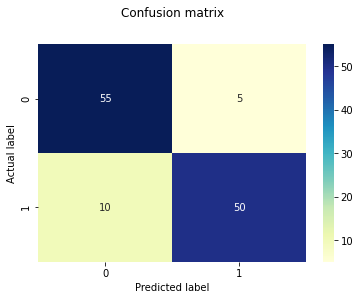

In [40]:
#confusion_matrix

y_pred = DT.predict(test_X)
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(test_Y, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [41]:
# Precision 
print(precision_score(model3_DT.predict(test_X),test_Y))
# Recall
print(recall_score(model3_DT.predict(test_X),test_Y))
# F1 − Score 
print(f1_score(model3_DT.predict(test_X),test_Y))

0.8333333333333334
0.9090909090909091
0.8695652173913043


In [42]:
#import classification_report
from sklearn.metrics import classification_report
print(classification_report(test_Y,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88        60
           1       0.91      0.83      0.87        60

    accuracy                           0.88       120
   macro avg       0.88      0.88      0.87       120
weighted avg       0.88      0.88      0.87       120



## Random Forest Classifier

In [24]:
rfc = RandomForestClassifier()

# Train the model
model4_rfc = rfc.fit(train_X, train_Y)

# Make a prediction
rfc_predict = model4_rfc.predict(test_X)

<ipython-input-24-38de031d0f6c>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model4_rfc = rfc.fit(train_X, train_Y)


In [25]:
# Compute the accuracy of the model
acc = accuracy_score(rfc_predict, test_Y)
print("Random Forest accuracy: " + str(acc))

Random Forest accuracy: 0.925


Text(0.5, 15.0, 'Predicted label')

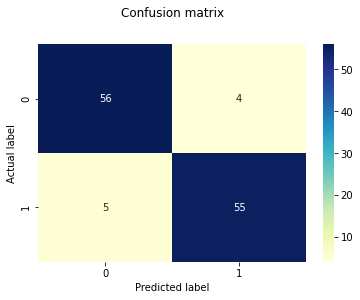

In [26]:
#confusion_matrix

y_pred = rfc.predict(test_X)
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(test_Y, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [28]:
# Precision 
print(precision_score(model4_rfc.predict(test_X),test_Y))
# Recall
print(recall_score(model4_rfc.predict(test_X),test_Y))
# F1 − Score 
print(f1_score(model4_rfc.predict(test_X),test_Y))

0.9166666666666666
0.9322033898305084
0.9243697478991596


In [29]:
#import classification_report
from sklearn.metrics import classification_report
print(classification_report(test_Y,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93        60
           1       0.93      0.92      0.92        60

    accuracy                           0.93       120
   macro avg       0.93      0.93      0.92       120
weighted avg       0.93      0.93      0.92       120



# Part 3: Getting Data from Instagram 

In [ ]:
def login():
    username = input("username: ")
    password = getpass.getpass("password: ")
    api = Client(username, password)
    return api

api = login()

In [ ]:
def get_ID(username):
    return api.username_info(username)['user']['pk']

In [ ]:
userID = get_ID('anonymous_acc121') 

In [ ]:
#The API needs some sort of rank to query followers, posts, etc.
rank = api.generate_uuid()

In [ ]:
#Get the user's list follower usernames 
def get_followers(userID, rank):
    followers = []
    next_max_id = True
    
    while next_max_id:
        if next_max_id == True: next_max_id=''
        f = api.user_followers(userID, rank, max_id=next_max_id)
        followers.extend(f.get('users', []))
        next_max_id = f.get('next_max_id', '')
    
    user_fer = [dic['username'] for dic in followers]
    
    return user_fer

In [ ]:
followers = get_followers(userID, rank)

In [ ]:
#Check the number of followers 
len(followers)

# Part 4: Preparing the Data

In [ ]:
# The first follower and the last username on the list
print(followers[0])
print(followers[-1])

In [ ]:
# This will get the information on a first user
informations = api.user_info(get_ID(followers[0]))['user']

# Check what information is available for one particular user
informations.keys()

In [ ]:
#We have almost all of the features we need to create a user data point for prediction,
#but we still have to filter and extract it, as well as do some computations.

def get_data(info):
    
    """Extract the information from the returned JSON.
    
    This function will return the following array:
        data = [profile pic,
                nums/length username,
                full name words,
                nums/length full name,
                name==username,
                description length,
                external URL,
                private,
                #posts,
                #followers,
                #followings]
    """
    
    data = []
    
    # Does the user have a profile photo?
    profile_pic = not info['has_anonymous_profile_picture']
    if profile_pic == True:
        profile_pic = 1
    else:
        profile_pic = 0
    data.append(profile_pic)
    
    # Ratio of number of numerical chars in username to its length
    username = info['username']
    uname_ratio = len([x for x in username if x.isdigit()]) / float(len(username))
    data.append(uname_ratio)
    
    # Full name in word tokens
    full_name = info['full_name']
    fname_tokens = len(full_name.split(' '))
    data.append(fname_tokens)
    
    # Ratio of number of numerical characters in full name to its length
    if len(full_name) == 0:
        fname_ratio = 0
    else:
        fname_ratio = len([x for x in full_name if x.isdigit()]) / float(len(full_name))
    data.append(fname_ratio)
    
    # Is name == username?
    name_eq_uname = (full_name == username)
    if name_eq_uname == True:
        name_eq_uname = 1
    else:
        name_eq_uname = 0
    data.append(name_eq_uname)
    
    # Number of characters on user bio 
    bio_length = len(info['biography'])
    data.append(bio_length)
    
    # Does the user have an external URL?
    ext_url = info['external_url'] != ''
    if ext_url == True:
        ext_url = 1
    else:
        ext_url = 0
    data.append(ext_url)
    
    # Is the user private or no?
    private = info['is_private']
    if private == True:
        private = 1
    else:
        private = 0
    data.append(private)
    
    # Number of posts
    posts = info['media_count']
    data.append(posts)
    
    # Number of followers
    followers = info['follower_count']
    data.append(followers)
    
    # Number of followings
    followings = info['following_count']
    data.append(followings)
    
  
    return data

In [ ]:
# Check if the function returns as expected
get_data(informations)

In [ ]:
#the Instagram Private API has a very limited number of API calls per hour so we will not be able to analyze all of the user's followers.

#for that, we took statistics and learned that random sampling is useful to cull
#a smaller sample size from a larger population and use it to research and make generalizations about the larger group.

#This will allow us to make user authenticity approximations despite the API limitations
#and still have data that is representative of the user's followers.

In [ ]:
# Get a random sample of 50 followers
random_followers = random.sample(followers, 50)

In [ ]:
#Get user information for each follower
f_infos = []

for follower in random_followers:
    info = api.user_info(get_ID(follower))['user']
    f_infos.append(info)

In [ ]:
f_table = []

for info in f_infos:
    f_table.append(get_data(info))
    
f_table

In [ ]:
# Create a dataframe

test_data = pd.DataFrame(f_table,
                         columns = ['profile pic', 
                                    'nums/length username', 
                                    'fullname words',
                                    'nums/length fullname',
                                    'name==username',
                                    'description length',
                                    'external URL',
                                    'private',
                                    '#posts',
                                    '#followers',
                                    '#follows'])
test_data

# Part 5:  The prediction

In [ ]:
#In part 2, we have compared the different classifiers
#and found that the Random Forest Classifier had the highest accuracy at 92.5%.
#Therefore, we are going to use this classifier to make the prediction.

rfc = RandomForestClassifier()

# Train the model
# We've done this in Part 2 but I'm redoing it here for coherence ☺️
rfc_model = rfc.fit(train_X, train_Y)

In [ ]:
rfc_labels = rfc_model.predict(test_data)
rfc_labels

In [ ]:
# Calculate the number of fake accounts in the random sample of 50 followers
no_fakes = len([x for x in rfc_labels if x==1])

In [ ]:
#Calculate the Instagram user's authenticity,
# Authenticity = (#followers - #fakes)*100 / #followers

In [ ]:
auth = (len(random_followers) - no_fakes) * 100 / len(random_followers)
print("User X's Instagram Followers is " + str(auth) + "% authentic.")

# Part 6: Fake Likes

In [ ]:
# Check fake likes within a post.
# Get the user's posts


def get_user_posts(userID, min_posts_to_be_retrieved):
    # Retrieve all posts from my profile
    my_posts = []
    has_more_posts = True
    max_id = ''
    
    while has_more_posts:
        feed = api.user_feed(userID, max_id=max_id)
        if feed.get('more_available') is not True:
            has_more_posts = False 
            
        max_id = feed.get('next_max_id', '')
        my_posts.extend(feed.get('items'))
        
        # time.sleep(2) to avoid flooding
        
        if len(my_posts) > min_posts_to_be_retrieved:
            print('Total posts retrieved: ' + str(len(my_posts)))
            return my_posts
            
        if has_more_posts:
            print(str(len(my_posts)) + ' posts retrieved so far...')
           
    print('Total posts retrieved: ' + str(len(my_posts)))
    
    return my_posts

In [ ]:
posts = get_user_posts(userID, 10)

In [ ]:
# Choose a single post to analyze (here we just going to Choose by random)

random_post = random.sample(posts, 1)

In [ ]:
random_post[0].keys()

In [ ]:
likers = api.media_likers(random_post[0]['id'])

In [ ]:
likers_usernames = [liker['username'] for liker in likers['users']]

In [ ]:
random_likers = random.sample(likers_usernames, 10)

In [ ]:
# Retrieve the information for the 10 users

l_infos = []

for liker in random_likers:
    info = api.user_info(get_ID(liker))['user']
    l_infos.append(info)

In [ ]:
l_table = []

for info in l_infos:
    l_table.append(get_data(info))

l_table

In [ ]:
# Generate a dataframe 
l_test_data = pd.DataFrame(l_table,
                         columns = ['profile pic', 
                                    'nums/length username', 
                                    'fullname words',
                                    'nums/length fullname',
                                    'name==username',
                                    'description length',
                                    'external URL',
                                    'private',
                                    '#posts',
                                    '#followers',
                                    '#follows'])
l_test_data

In [ ]:
# The prediction

rfc = RandomForestClassifier()
rfc_model = rfc.fit(train_X, train_Y)
rfc_labels_likes = rfc_model.predict(l_test_data)
rfc_labels_likes

In [ ]:
no_fake_likes = len([x for x in rfc_labels_likes if x==1])

In [ ]:
media_auth = (len(random_likers) - no_fake_likes) * 100 / len(random_likers)
print("The media with the ID:XXXXX has " + str(media_auth) + "% authentic likes.")

# Part 7: Comparison With Another Account

In [ ]:
api = login()

In [ ]:
userID_y = get_ID('test_acc00_')

In [ ]:
rank = api.generate_uuid()

In [ ]:
#USER test_acc00_ FOLLOWERS ANALYSIS
test_acc00__followers = get_followers(userID_y, rank)

In [ ]:
y_random_followers = random.sample(test_acc00__followers, 3)

In [ ]:
y_infos = []

for follower in y_random_followers:
    info = api.user_info(get_ID(follower))['user']
    y_infos.append(info)

In [ ]:
y_table = []

for info in y_infos:
    y_table.append(get_data(info))
    
y_table

In [ ]:
# Dataframe 
y_test_data = pd.DataFrame(y_table,
                         columns = ['profile pic', 
                                    'nums/length username', 
                                    'fullname words',
                                    'nums/length fullname',
                                    'name==username',
                                    'description length',
                                    'external URL',
                                    'private',
                                    '#posts',
                                    '#followers',
                                    '#follows'])
y_test_data

In [ ]:
# Predict 
rfc_labels_y = rfc_model.predict(y_test_data)
rfc_labels_y

In [ ]:
# Calculate the number of fake accounts
no_fakes_y = len([x for x in rfc_labels_y if x==1])

In [ ]:
# Calculate the authenticity
y_authenticity = (len(y_random_followers) - no_fakes_y) * 100 / len(y_random_followers)
print("User Y's Instagram Followers is " + str(y_authenticity) + "% authentic.")